In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.optim as optim

import functions2d as fun

### function to learn:

In [2]:
which = 'p5'

plot of the function to learn:

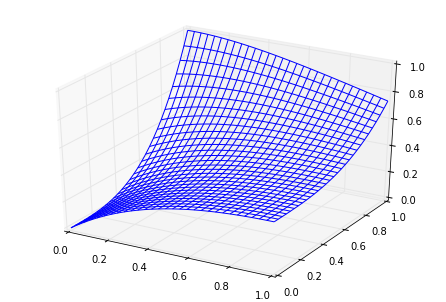

In [3]:
x1_min_show, x1_max_show, x2_min_show, x2_max_show = fun.interval[which]
x1_show = np.linspace(x1_min_show, x1_max_show, 30)
x2_show = np.linspace(x2_min_show, x2_max_show, 30)

X1_show, X2_show = np.meshgrid(x1_show, x2_show)
y_show = fun.function[which](X1_show, X2_show)
fig = plt.figure()
ax = Axes3D(fig)
cset = ax.plot_wireframe(X1_show, X2_show, y_show)

model parameters:
* D_in: dimension of the input
* H: dimension of the hidden layer
* D_out: dimension of the output

In [4]:
D_in, H, D_out = 2, 10, 1

#### training set:

In [5]:
x1_min, x1_max, x2_min, x2_max = fun.interval[which]
n_train = 10 

x1_train = np.linspace(x1_min, x1_max, n_train)
x2_train = np.linspace(x2_min, x2_max, n_train)
X1_train, X2_train = np.meshgrid(x1_train, x2_train)

y_train = fun.function[which](X1_train, X2_train)

x = Variable(torch.cat((torch.Tensor(X1_train).view(-1, 1), torch.Tensor(X2_train).view(-1, 1)), 1))
y = Variable(torch.Tensor(y_train), requires_grad=False)

### Neural net:

In [7]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

#loss_fn = torch.nn.MSELoss(size_average=False)
criterion = torch.nn.L1Loss(size_average=False)
#optimizer = optim.SGD(seq.parameters(), lr = 5e-6, momentum=0.9)
optimizer = optim.Adam(seq.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

#### Learning:

In [8]:
n_epoch = 80000
Loss = []
for t in tqdm(range(n_epoch)):    
    y_pred = fun.trial[which](seq, x)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    Loss.append(loss.data.numpy()[0])

100%|██████████| 80000/80000 [00:35<00:00, 2247.75it/s]


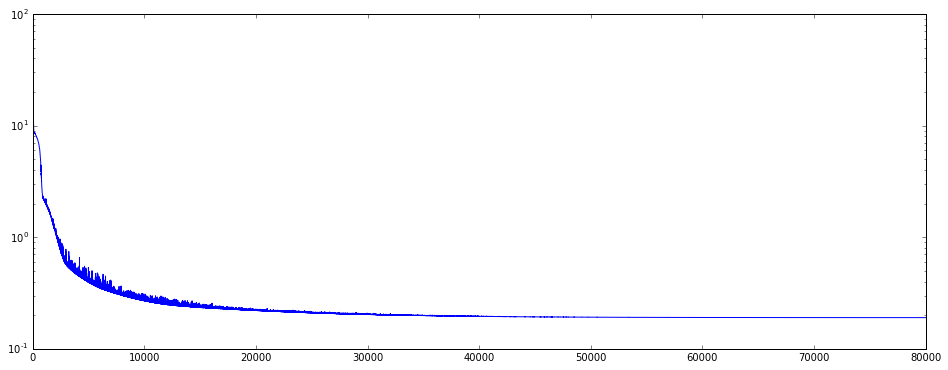

In [9]:
plt.figure(figsize=(16, 6))
plt.semilogy(Loss) 
plt.show()

### Testing:

In [58]:
n_test = 50
x1_min_test, x1_max_test, x2_min_test, x2_max_test = fun.interval[which]

x1_test = np.linspace(x1_min_test, x1_max_test, n_test)
x2_test = np.linspace(x2_min_test, x2_max_test, n_test)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
x_test = Variable(torch.cat((torch.Tensor(X1_test).view(-1, 1), torch.Tensor(X2_test).view(-1, 1)), 1))

y_test = fun.function[which](X1_test, X2_test)

##### Trial solution:

In [59]:
y_pred = fun.trial[which](seq, x_test).view(y_test.shape)
print(criterion(y_pred, Variable(torch.Tensor(y_test))))

Variable containing:
 3.6846
[torch.FloatTensor of size 1]



#### Plot of results:

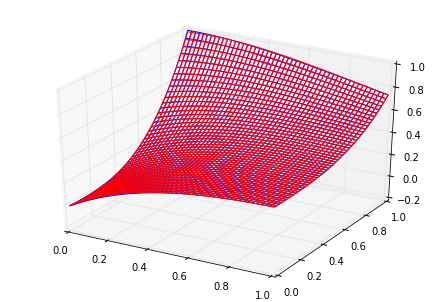

In [60]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X1_test, X2_test, y_test, color='b', label='real')
ax.plot_wireframe(X1_test, X2_test, y_pred.data.numpy(), color='r', label='predicted')

plt.show()

### Error:

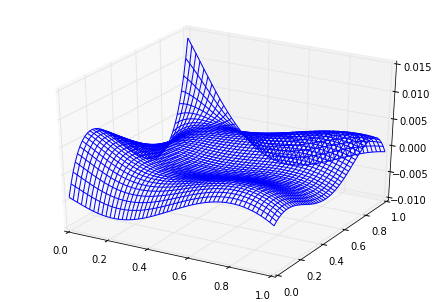

In [61]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X1_test, X2_test, y_test-y_pred.data.numpy())
#plt.legend(scatterpoints=1)
plt.show()

### Naive solution (linear interpolation): (TODO)

In [ ]:
def naive(xtrain, ytrain, xtest):
    ytest = []
    x_max_train = xtrain.numpy()[-1]
    for x in xtest:
        if x.data.numpy()[0] >= x_max_train:
            ytest.append(0)
            continue
        for i, xt in enumerate(xtrain):
            #print(x.data.numpy())#, xt.numpy()[0])
            if x.data.numpy()[0] < xt.numpy()[0]:
                ytest.append(float((ytrain[i-1] + (ytrain[i]-ytrain[i-1])*(x.data.numpy()[0]-xtrain[i-1])/(xtrain[i]-xtrain[i-1])).numpy()[0]))
                break
    return ytest

In [ ]:
y_naive = naive(x_train, y_train, x_test)

In [ ]:
plt.figure(figsize=(16, 6))
plt.scatter(x.data.numpy(), y.data.numpy(), c='g', s=50) #training set
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='b', s=1, edgecolors='none', label='real') # test real
plt.scatter(x_test.data.numpy(), y_pred.data.numpy(), c='r', s=1, edgecolors='none', label='predicted') # test predicted
plt.scatter(x_test.data.numpy(), y_naive, c='k', s=1, edgecolors='none')
plt.legend(scatterpoints=1)
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
plt.scatter(x_test.data.numpy(), (y_test-y_pred).data.numpy(), s=1, c='r', edgecolors='none', label='NN')
plt.scatter(x_test.data.numpy(), y_test.view(1, -1).data.numpy()-y_naive, s=1, c='k', edgecolors='none', label='Naive')
plt.legend(scatterpoints=1)
plt.ylim(-0.1, 0.1)
plt.show()

In [ ]:
print('predicted:', criterion(y_pred[:int(len(y_pred)/2)], y_test[:int(len(y_pred)/2)]))
print('naive:', criterion(Variable(torch.Tensor(y_naive[:int(len(y_pred)/2)])), y_test[:int(len(y_pred)/2)]))